# Introduction

This notebook contains an analysis of the simulation `Transport`. A species is is diffusing freely ($D$ = 0.1 $\mu$m$^2/$s) in an absorbing corral (radius 25 $\mu$m) with a few railways to which it can bind. It unbinds at a certain rate. 

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.functions import TE_MSD,Michalet,set_size,pool_data
from sklearn.cluster import KMeans
import matplotlib as mpl
import seaborn as sns
import random

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=12
maxframe=100000
rsquared_threshold=-1000

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [2]:
#Preprocess the Smoldyn exact trajectories
data = pd.read_csv('Transport/output.txt', sep=" ", header=None)
data.columns = ["iteration", "useless1", "useless2", "POSITION_X","POSITION_Y","TRACK_ID"]
data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Transport/temp.csv',index=None)

In [3]:
files = ["Transport/temp.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=4,display_id=True)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  12 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  4
Reading filenames in  ['Transport/temp.csv'] ...
Analysis for Transport/temp.csv ...
Track 0 out of 500
Track 1 out of 500
Track 2 out of 500
Track 3 out of 500
Track 4 out of 500
Track 5 out of 500
Track 6 out of 500
Track 7 out of 500
Track 8 out of 500
Track 9 out of 500
Track 10 out of 500
Track 11 out of 500
Track 12 out of 500
Track 13 out of 500
Track 14 out of 500
Track 15 out of 500
Track 16 out of 500
Track 17 out of 500
Track 18 out of 500
Track 19 out of 500
Track 20 out of 500
Track 21 out of 500
Track 22 out of 500
Track 23 out of 500
Track 24 out of 500
Track 25 out of 500
Track 26 out of 500
Track 27 out of 500
Track 28 out of 500
Track 29 out of 500
Track 30 out of 500
Track 31 out of 500
Track 32 out of 500
Track 33 out of 500
Track 34 out of 500
Track 35 out of 500
Track 36 out of 500
Track 37 out of 500
Track 38 out of 500
Track 39 

Track 385 out of 500
Track 386 out of 500
Track 387 out of 500
Track 388 out of 500
Track 389 out of 500
Track 390 out of 500
Track 391 out of 500
Track 392 out of 500
Track 393 out of 500
Track 394 out of 500
Track 395 out of 500
Track 396 out of 500
Track 397 out of 500
Track 398 out of 500
Track 399 out of 500
Track 400 out of 500
Track 401 out of 500
Track 402 out of 500
Track 403 out of 500
Track 404 out of 500
Track 405 out of 500
Track 406 out of 500
Track 407 out of 500
Track 408 out of 500
Track 409 out of 500
Track 410 out of 500
Track 411 out of 500
Track 412 out of 500
Track 413 out of 500
Track 414 out of 500
Track 415 out of 500
Track 416 out of 500
Track 417 out of 500
Track 418 out of 500
Track 419 out of 500
Track 420 out of 500
Track 421 out of 500
Track 422 out of 500
Track 423 out of 500
Track 424 out of 500
Track 425 out of 500
Track 426 out of 500
Track 427 out of 500
Track 428 out of 500
Track 429 out of 500
Track 430 out of 500
Track 431 out of 500
Track 432 out

# Gaussian mixture to identify clusters

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=5000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=1000)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1,2]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_transported = D_per_group.index(min(D_per_group))
index_free = list(filter(lambda x : x != index_transported, index)) #careful, two different indexes

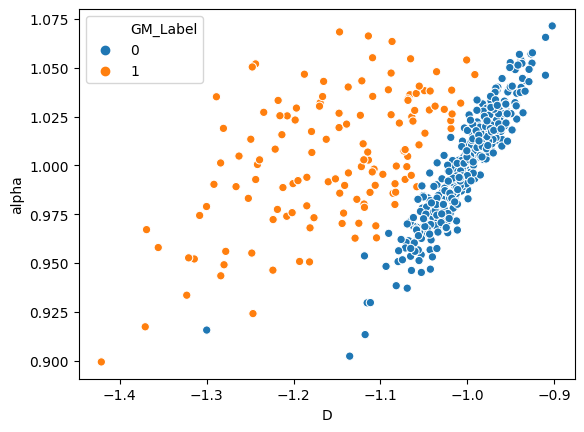

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.scatterplot(x='D',y='alpha',hue='GM_Label',data=df)
plt.show()

# MSDs with cluster label

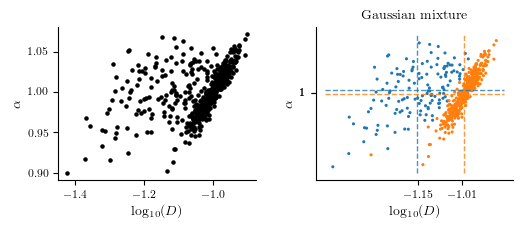

In [6]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_transported else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_transported)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_free[0]) | (df['GM_Label']==index_free[1])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_transported)].mean()
meanD0 = df['D'][(df['GM_Label']==index_free[0]) | (df['GM_Label']==index_free[1])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Transport/Plots/transport_exact_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

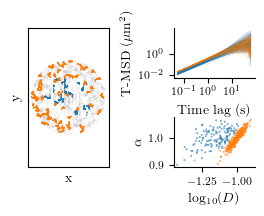

In [7]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(100))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Transport/Plots/transport_exact_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


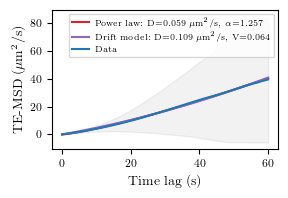

In [8]:
MSDtransported = list(df['MSD'][(df['GM_Label']==index_transported)].values)
temsd,var,timelag = TE_MSD(MSDtransported,plot=False)

from scipy.optimize import curve_fit

def transport_model(timelag, D, alpha):
    return(4*D*timelag**alpha)

def drift_model(timelag, D, V):
    return(4*D*timelag + V**2*timelag**2)

popt1, pcov1 = curve_fit(transport_model, timelag, temsd)
popt2, pcov2 = curve_fit(drift_model, timelag, temsd)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, transport_model(timelag, *popt1), '-',label=r'Power law: D=%5.3f $\mu$m$^2/$s, $\alpha$=%5.3f' % tuple(popt1),c='tab:red')
ax.plot(timelag, drift_model(timelag, *popt2), '-',label=r'Drift model: D=%5.3f $\mu$m$^2/$s, V=%5.3f' % tuple(popt2),c='tab:purple')
ax.plot(timelag,temsd,label='Data',c='tab:blue')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
#ax.set_xlim(0.05,5)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.savefig('Transport/Plots/transport_exact_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Simulated movie

In [9]:
minframe=15
files = ["Transport/movie/tracks.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[1,5])

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  [1, 5]
Reading filenames in  ['Transport/movie/tracks.csv'] ...
Analysis for Transport/movie/tracks.csv ...
6974  tracks were kept out of  518589 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


# Select sample size 

You should take count as sample size.

In [10]:
display(df.describe())
N = 6974
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,6974.000000,6.974000e+03,6974.000000,6974.000000,6974.000000
mean,0.674704,-1.121585e+00,0.119618,-1.008984,71.624319
std,0.238682,2.822413e-01,0.088050,5.949346,71.771455
min,0.100000,-3.383196e+00,0.000140,-105.421129,15.000000
25%,0.543890,-1.258645e+00,0.056286,-0.408632,26.000000
50%,0.685137,-1.098361e+00,0.099253,0.320487,48.000000
75%,0.815230,-9.630207e-01,0.159145,0.742597,91.000000
max,1.773241,-5.785965e-16,0.913416,0.998631,1034.000000


# Test the influence of MinFrame and $R^2$

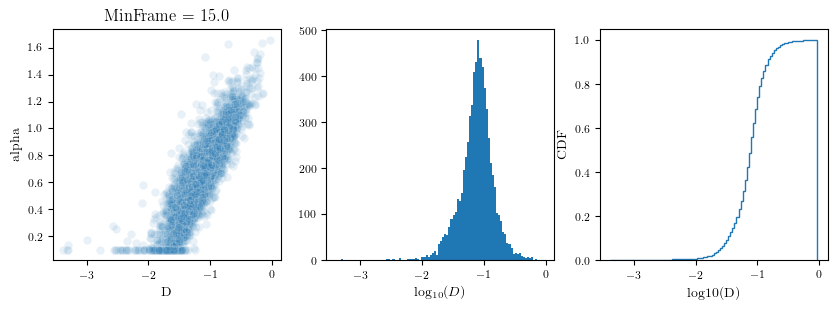

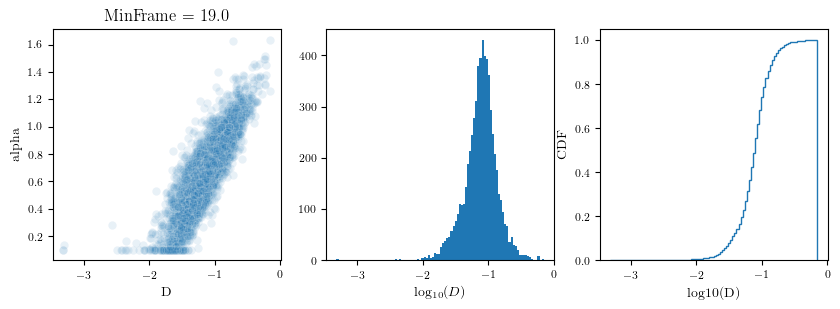

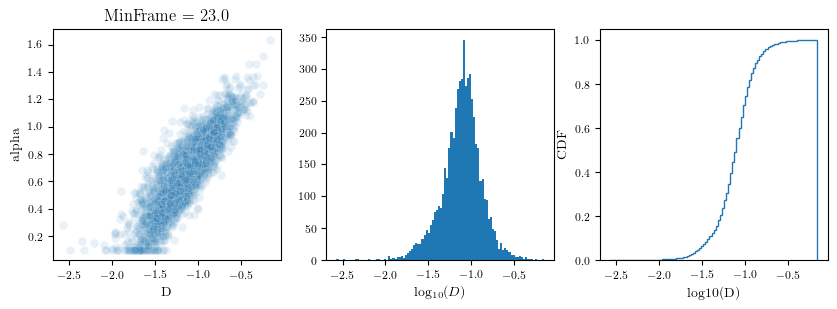

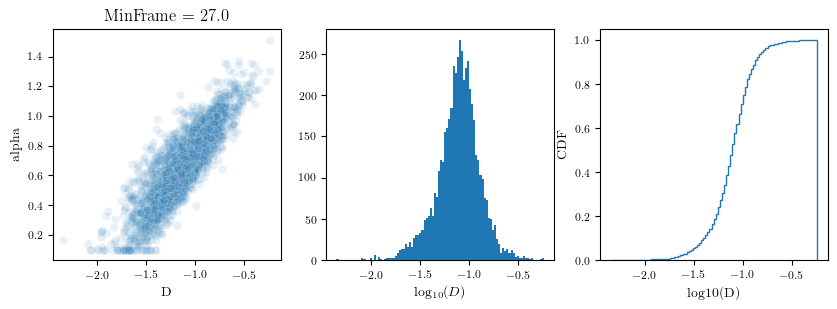

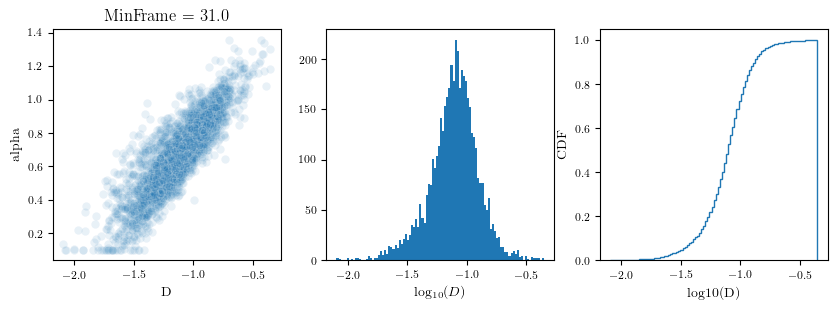

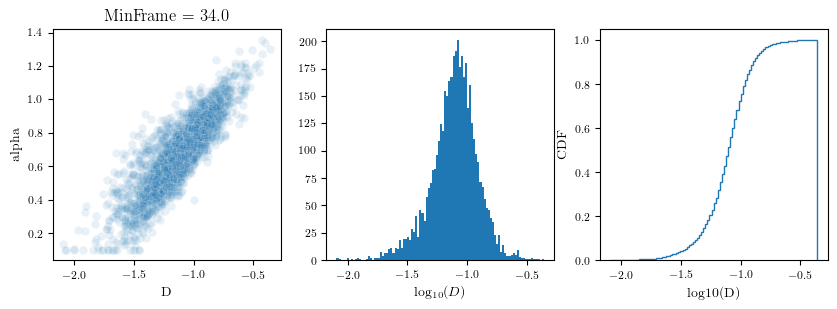

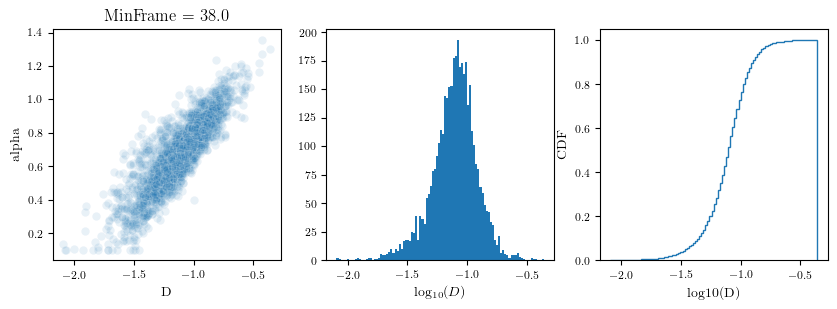

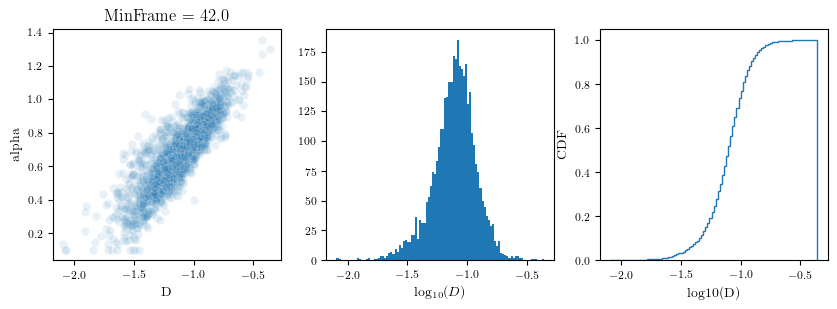

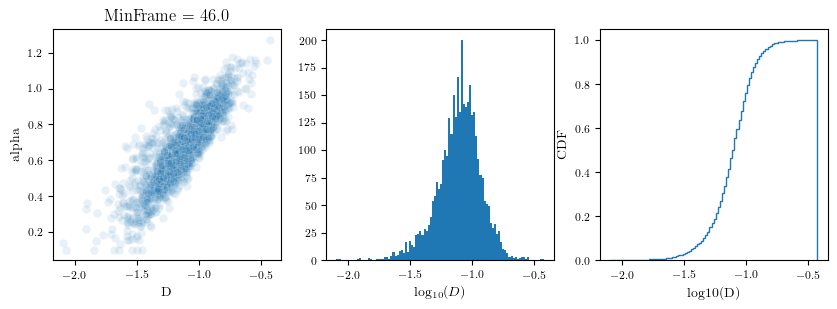

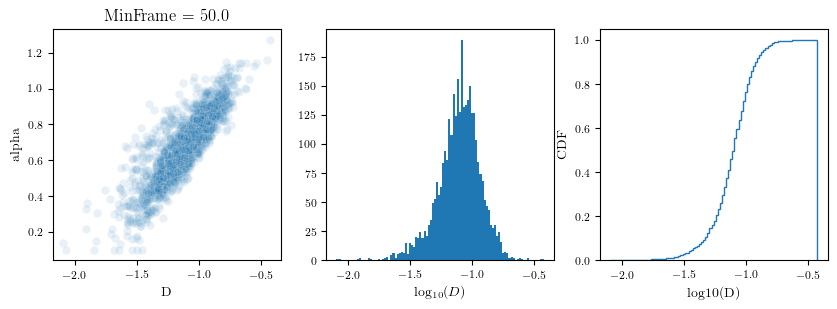

In [11]:
N = np.linspace(minframe,50,10)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>-1000)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

# Set Minframe, $R^2$ and apply a Gaussian mixture on the resulting dataset

In [12]:
minframe = 50
r2 = -1000
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=1000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=500)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_transported = D_per_group.index(min(D_per_group))
index_free = list(filter(lambda x : x != index_transported, index)) #careful, two different indexes
print("Index for the transported particles is = ",index_transported)

Index for the transported particles is =  1


/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


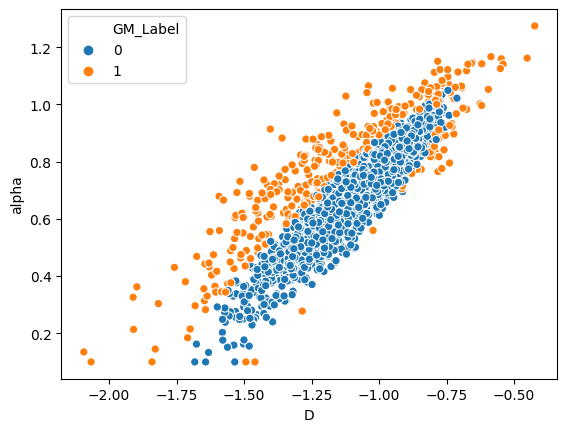

In [13]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.scatterplot(x='D',y='alpha',hue='GM_Label',data=df)
plt.show()

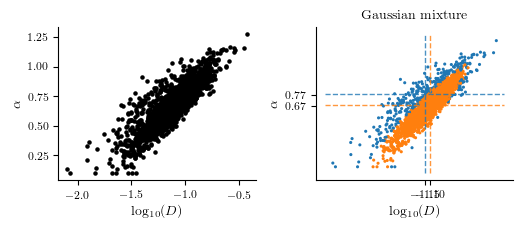

In [14]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_transported else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_transported)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_free[0])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_transported)].mean()
meanD0 = df['D'][(df['GM_Label']==index_free[0])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Transport/Plots/transport_movie_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Use the GM-determined labels to visualize trajectories and MSDs

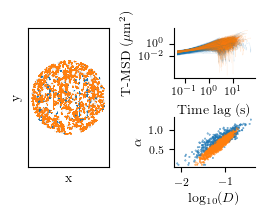

In [15]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(2000))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Transport/Plots/transport_movie_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Perform specific analysis on the believed to be confined trajectories

Compute the TE-MSD and ensemble variance...
You have set a cutoff at  15  s...
Done. The TE-MSD and associated variance have been generated.


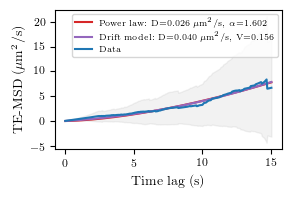

In [16]:
MSDtransported = list(df['MSD'][(df['GM_Label']==index_transported)].values)
temsd,var,timelag = TE_MSD(MSDtransported,plot=False,cutoff=15)

from scipy.optimize import curve_fit

def transport_model(timelag, D, alpha):
    return(4*D*timelag**alpha)

def drift_model(timelag, D, V):
    return(4*D*timelag + V**2*timelag**2)

popt1, pcov1 = curve_fit(transport_model, timelag, temsd)
popt2, pcov2 = curve_fit(drift_model, timelag, temsd)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, transport_model(timelag, *popt1), '-',label=r'Power law: D=%5.3f $\mu$m$^2/$s, $\alpha$=%5.3f' % tuple(popt1),c='tab:red')
ax.plot(timelag, drift_model(timelag, *popt2), '-',label=r'Drift model: D=%5.3f $\mu$m$^2/$s, V=%5.3f' % tuple(popt2),c='tab:purple')
ax.plot(timelag,temsd,label='Data',c='tab:blue')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
#ax.set_xlim(0.05,5)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.savefig('Transport/Plots/transport_movie_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()